## Evaluate compressed sensing task

In [37]:
def run_descent(generator, x, A, y, print_out=False, z_dimension=2, lr=0.01):

    criterion = nn.MSELoss()
    
#     z = torch.randn((1,z_dimension), dtype=torch.float32) 
    z = torch.zeros((1,z_dimension), dtype=torch.float32)
    z = z.to('cuda')
    
    # First select a good random vector
    min_criterion = 9999999
    for i in range(400):
        temp = torch.randn((1,z_dimension), dtype=torch.float32)
        temp = temp.to('cuda')
        temp_out = generator(temp)
#         temp_out = temp_out.permute(0,1,3,2)
        x_hat = temp_out
        temp_criterion = criterion(torch.matmul(A, x_hat), y) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_first', min_criterion.item())

    for i in range(200):
        temp = 0.2*torch.randn((1,z_dimension), dtype=torch.float32).to('cuda') + z
#         temp = temp.to('cuda')
        temp_out = generator(temp)
#         temp_out = temp_out.permute(0,1,3,2)
        x_hat = temp_out
        temp_criterion = criterion(torch.matmul(A, x_hat), y) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_second', min_criterion.item())

    z.requires_grad = True
    
    optimizer = torch.optim.Adam([z], lr=0.01)
    
    num_iter = 0
    loss_prev = 999999
    loss_current = 999
    max_iter = 200
    loss_change_threshold = 0.000001
    while num_iter < max_iter: # and (loss_prev - loss_current > loss_change_threshold):
        print(loss_prev-loss_current)
        loss_prev = loss_current
        optimizer.zero_grad()
        
        x_hat = generator(z)
        
        loss = criterion(torch.matmul(A, x_hat), y)
        
        loss.backward()
        optimizer.step()

        if print_out:
            clear_output(wait=True)
            actual_loss = torch.norm(x - x_hat)/torch.norm(x)
            print(num_iter, actual_loss.item(), torch.norm(z))
            time.sleep(0.01)
        loss_current = loss.item()
        num_iter += 1
    
    return x_hat, actual_loss

## Load dataset

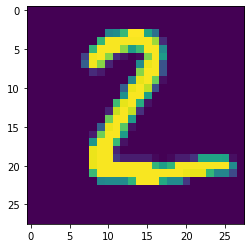

In [75]:
import torch
import matplotlib.pyplot as plt
from dataset import MNISTDataset, MNISTFlowDataset
import numpy as np
import torch.nn as nn
from IPython.display import clear_output
import time

latent_train_set = MNISTFlowDataset(path='data/MNIST/latent')
image_train_set = MNISTDataset(path='data/MNIST/processed', normalize=True)

latent_test_set = MNISTFlowDataset(path='data/MNIST/latent', train=False)
image_test_set = MNISTDataset(path='data/MNIST/processed', train=False, normalize=True)

num_observations = 5
A = torch.randn((num_observations, 28), dtype=torch.float32)
x = image_test_set[2]
y = torch.matmul(A, x)

A = A.to('cuda')
x = x.to('cuda')
y = y.to('cuda')

def show_image(x):
    plt.imshow(x.to('cpu').detach().squeeze().numpy())
show_image(x)    

## Autoencoder

499 0.9615607261657715 tensor(4.1344, device='cuda:0', grad_fn=<CopyBackwards>)


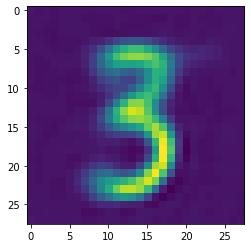

In [23]:
autoencoder = torch.load('trained_models/mnist_ae_noact.model')
autoenocder = autoencoder.to('cuda')
autoencoder.eval()

x_hat = run_descent(autoencoder.decoder, x, A, y, print_out=True, z_dimension=2, lr=0.01)
show_image(x_hat)

## Flow model

499 0.5648733973503113 tensor(2.0640, device='cuda:0', grad_fn=<CopyBackwards>)


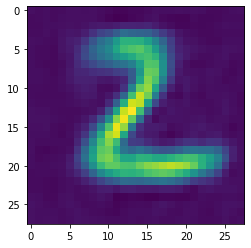

In [24]:
class Generator:
    def __init__(self):
        self.flow_model = torch.load('trained_models/mnist_flow_3.model')
        self.flow_model = self.flow_model.to('cuda')
        self.flow_model.eval()
        self.autoencoder = torch.load('trained_models/mnist_ae_noact.model')
        self.autoenocder = self.autoencoder.to('cuda')
        self.autoencoder.eval()
        
    def __call__(self, z):
        z = z.to('cuda')
        z = self.flow_model.reverse(z)
        return self.autoencoder.decoder(z)
    
# import flow model
# flow_model = torch.load('trained_models/mnist_flow_3.model')


# cuda_latent_train = latent_train_set.dataset.to('cuda')

generator = Generator()

x_hat = run_descent(generator, x, A, y, print_out=True, z_dimension=2, lr=0.01)
show_image(x_hat)

## AAE

199 1.0618841648101807 tensor(37.9670, device='cuda:0', grad_fn=<CopyBackwards>)


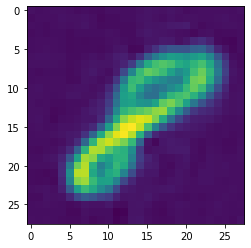

In [36]:
aae_model = torch.load('trained_models/mnist_aae_1.model')
# aae_model = torch.load('trained_models/mnist_aae_semisupervised_r_100_2.model')

aae_model = aae_model.to('cuda')
aae_model.eval()

x_hat,_ = run_descent(aae_model.autoencoder.decoder, x, A, y, print_out=True, z_dimension=2, lr=0.01)
show_image(x_hat)

## VAE

499 0.7730712890625 tensor(0.6771, device='cuda:0', grad_fn=<CopyBackwards>)


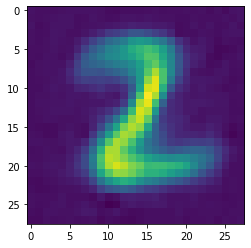

In [26]:
vae_model = torch.load('trained_models/vae_mnist_zdim_2.model')
vae_model = vae_model.to('cuda')
vae_model.eval()

x_hat = run_descent(vae_model.decode, x, A, y, print_out=True, z_dimension=2, lr=0.01)
show_image(x_hat)

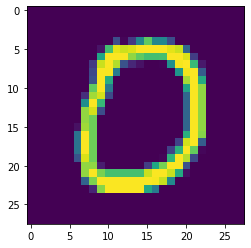

In [82]:
import torch
import matplotlib.pyplot as plt
from dataset import MNISTDataset, MNISTFlowDataset
import numpy as np
import torch.nn as nn
from IPython.display import clear_output
import time

latent_train_set = MNISTFlowDataset(path='data/MNIST/latent')
image_train_set = MNISTDataset(path='data/MNIST/processed', normalize=True)

latent_test_set = MNISTFlowDataset(path='data/MNIST/latent', train=False)
image_test_set = MNISTDataset(path='data/MNIST/processed', train=False, normalize=True)

num_observations = 5
A = torch.randn((num_observations, 28), dtype=torch.float32)
x = image_test_set[10]
y = torch.matmul(A, x)

A = A.to('cuda')
x = x.to('cuda')
y = y.to('cuda')

def show_image(x):
    plt.imshow(x.to('cpu').detach().squeeze().numpy())
show_image(x)    

In [83]:
x_ae  , err_ae = run_descent(autoencoder.decoder, x, A, y, print_out=True, z_dimension=2, lr=0.01)
x_flow, err_flow = run_descent(generator, x, A, y, print_out=True, z_dimension=2, lr=0.01)
x_aae , err_aae = run_descent(aae_model.autoencoder.decoder, x, A, y, print_out=True, z_dimension=2, lr=0.01)
x_vae , err_vae = run_descent(vae_model.decode, x, A, y, print_out=True, z_dimension=2, lr=0.01)



199 0.5395735502243042 tensor(2.3224, device='cuda:0', grad_fn=<CopyBackwards>)


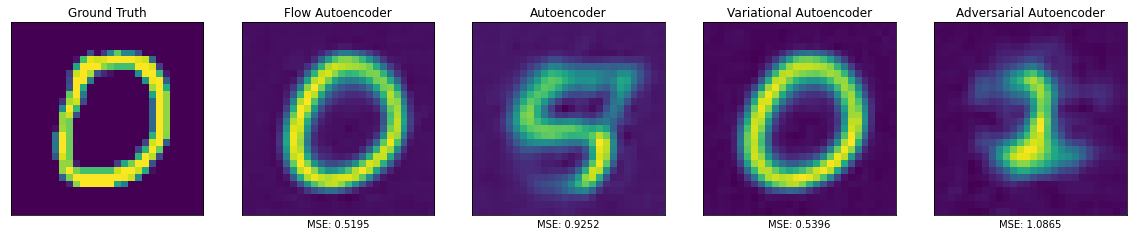

In [85]:
fig, axes = plt.subplots(1,5, figsize=(20,20))

axes[0].imshow(x.to('cpu').detach().squeeze().numpy())
axes[0].set_title('Ground Truth')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(x_flow.to('cpu').detach().squeeze().numpy())
axes[1].set_title('Flow Autoencoder')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('MSE: {:.4f}'.format(err_flow))


axes[2].imshow(x_ae.to('cpu').detach().squeeze().numpy())
axes[2].set_title('Autoencoder')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel('MSE: {:.4f}'.format(err_ae))

# axes[1,1].set_title('Autoencoder')

axes[3].imshow(x_vae.to('cpu').detach().squeeze().numpy())
axes[3].set_title('Variational Autoencoder')
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_xlabel('MSE: {:.4f}'.format(err_vae))

axes[4].imshow(x_aae.to('cpu').detach().squeeze().numpy())
axes[4].set_title('Adversarial Autoencoder')
axes[4].set_xticks([])
axes[4].set_yticks([])
axes[4].set_xlabel('MSE: {:.4f}'.format(err_aae))

fig.savefig('data/cs_recons.pdf')